In [339]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt

import keras.backend as K

import tensorflow as tf

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, AveragePooling2D, AveragePooling1D
from keras.metrics import BinaryAccuracy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

In [410]:
# X = np.load('ABIDE_X.npy', allow_pickle=True)
# Y = np.load('ABIDE_Y.npy', allow_pickle=True)
# X = np.load('total_X.npy', allow_pickle=True)
# Y = np.load('total_Y.npy', allow_pickle=True)
X = np.load('ABIDE_X.npy', allow_pickle=True)
Y = np.load('ABIDE_Y.npy', allow_pickle=True)

In [341]:
vals = np.empty((0,))
for s in X:
  vals = np.append(vals, s.flatten())


In [342]:
roi_ss = StandardScaler()
roi_ss.fit(vals.reshape(-1, 1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [343]:
del vals

In [344]:
# Since scans are 2s apart 90 scans is 3 mins
L = 10
# Number of clips per subject
N=10
# Number of ROIs
N_rois = 200
feat_name = 'filt_noglobal_roi_200_Cradd'
def extract_feat_sections(data, L=L, N=N):
    feat_secs = list()
    for i in range(N):
        r = int(random.random() * (len(data) - L))
        feat_secs.append(data[r:r+L])
    return np.array(feat_secs)

def create_dataset(X_arr, Y_arr, L=L,N=N):
    X = list()
    Y = list()
    for n, data in enumerate(X_arr):
        feat_secs = extract_feat_sections(data)
        X.extend(feat_secs)
        for i in range(len(feat_secs)):
            Y.append(Y_arr[n, 2])
    assert len(X) == len(Y)
    X_ar = np.array(X).reshape(len(X), L, N_rois)
    Y_ar = np.array(Y)
    return X_ar, Y_ar

In [345]:
# Since scans are 2s apart 90 scans is 3 mins
# L = 90
L = 10
# Number of clips per subject
# N=10
N = 10
# Number of ROIs
N_rois = 200
# Number of ROIS to swap
# N_swap_rois = int(L *.1)
N_swap_rois = 2

def swap_rois(feat_sec):
  swapped_feat_sec = copy.deepcopy(feat_sec)
  swap_indexes = set()
  # select random indexes to swap
  while len(swap_indexes) < N_swap_rois:
    swap_indexes.add(random.randint(0,L-1))
  swap_indexes_l = list(swap_indexes)
  swap_indexes_l_2 = copy.deepcopy(swap_indexes_l)
  # ensure no indexes are the same in two lists
  same = True
  while same:
    same = False  
    random.shuffle(swap_indexes_l)
    for n, i in enumerate(swap_indexes_l):
      dist = np.linalg.norm(feat_sec[i]-feat_sec[swap_indexes_l_2[n]])
      if(dist == 0):
        same = True
  for n, i in enumerate(swap_indexes_l):
    swapped_feat_sec[i] = feat_sec[n]
  # generate swap label
  swap_label = np.zeros((L, ))
  for i in swap_indexes_l:
    swap_label[i] = 1
  # run again if didn't properly swap
  good_swap = True
  for i, roi in enumerate(feat_sec):
    dist = np.linalg.norm(roi-swapped_feat_sec[i])
    if dist > 0:
      if i not in swap_indexes:
        good_swap = False
    else:
      if i in swap_indexes:
        good_swap = False
  if good_swap:
    return swapped_feat_sec, swap_label
  else:
    return swap_rois(feat_sec)

def create_pretraining_dataset(X_arr, Y_arr, L=L,N=N):
    X = list()
    Y = list()
    for n, data in enumerate(X_arr):
        feat_secs = extract_feat_sections(data)
        for feat_sec in feat_secs:
          feat_sec_swapped, swap_label = swap_rois(feat_sec)
          X.append(feat_sec_swapped)
          Y.append(swap_label)
    assert len(X) == len(Y)
    X_ar = np.array(X).reshape(len(X), L, N_rois)
    Y_ar = np.array(Y)
    return X_ar, Y_ar

In [346]:
# Since scans are 2s apart 90 scans is 3 mins
L = 90
# Number of clips per subject
N=10
# Number of ROIs
N_rois = 200

def create_pretraining_dataset_next_pred(X_arr, Y_arr, L=L,N=N):
    X = list()
    Y = list()
    for n, data in enumerate(X_arr):
        feat_secs = extract_feat_sections(data, L+1)
        for feat_sec in feat_secs:
          norm_feat_sec =  feat_sec[0:L] / np.linalg.norm(feat_sec[0:L])
          # norm_feat_sec = feat_sec[0:L]
          X.append(norm_feat_sec)
          # norm_next = feat_sec[-1] / np.linalg.norm(feat_sec[-1])
          next = feat_sec[-1]
          Y.append(next)
    assert len(X) == len(Y)
    X_ar = np.array(X).reshape(len(X), L, N_rois)
    Y_ar = np.array(Y)
    return X_ar, Y_ar

In [439]:
# Since scans are 2s apart 90 scans is 3 mins
L = 90
# Number of clips per subject
N = int(10*90/L)
# Number of ROIs
N_rois = 200
feat_name = 'filt_noglobal_roi_200_Cradd'

def create_pretraining_dataset_total(X_arr, Y_arr, L=L,N=N, gender_even=False, roi_ss=None):
    X = list()
    Y_pred_n = list()
    Y_gen = list()
    Y_age = list()
    Y_asd = list()
    # calculate percentage of X_arr that is female
    for n, data in enumerate(X_arr):
        # Number of secs to pull proporational to length of data
        N_secs = int(N*data.shape[0]/100)
        feat_secs = extract_feat_sections(data, L+1, N_secs)
        for feat_sec in feat_secs:
          # norm_feat_sec =  feat_sec[0:L] / np.linalg.norm(feat_sec[0:L])
          norm_feat_sec = roi_ss.transform(feat_sec[0:L])
          X.append(norm_feat_sec)
          # norm_next = feat_sec[-1] / np.linalg.norm(feat_sec[-1])
          next = feat_sec[-1]
          if roi_ss is not None:
            # p_n = list()
            # for n in next:
            #   p_n.append(np.float32(n))
            # next = roi_ss.transform(np.array(p_n).reshape(1, 200)) 
            next = roi_ss.transform(next.reshape(-1, 1)) 
          # Y.append(np.array([norm_next, Y_arr[n][0], Y_arr[n][1]]))
          Y_pred_n.append(next)
          Y_gen.append(int(Y_arr[n][0]))
          Y_age.append([Y_arr[n][1]])
          Y_asd.append(int(Y_arr[n][2]))
    if gender_even:
      p = Y_gen.count(0) / Y_gen.count(1)
      X_even = list()
      Y_pred_n_even = list()
      Y_gen_even = list()
      Y_age_even = list()
      Y_asd_even = list()
      for n, g in enumerate(Y_gen):
        if g == 0:
          X_even.append(X[n])
          Y_pred_n_even.append(Y_pred_n[n])
          Y_gen_even.append(0)
          Y_age_even.append(Y_age[n])
          Y_asd_even.append(Y_asd[n])
        else:
          r = random.random()
          if r <= p:
            X_even.append(X[n])
            Y_pred_n_even.append(Y_pred_n[n])
            Y_gen_even.append(1)
            Y_age_even.append(Y_age[n])
            Y_asd_even.append(Y_asd[n])
      X = X_even
      Y_pred_n = Y_pred_n_even
      Y_gen = Y_gen_even
      Y_age = Y_age_even
      Y_asd = Y_asd_even

    
    assert len(X) == len(Y_pred_n) == len(Y_gen) == len(Y_age) == len(Y_asd)
    X_ar = np.array(X).reshape(len(X), L, N_rois)
    return X_ar, np.array(Y_pred_n), np.array(Y_gen), np.array(Y_age), np.array(Y_asd)

In [440]:
# To start will just randomly split subjects into groups
random_seed = 46
val_per = .1
test_per = 0
train_sub_X, val_sub_X, train_sub_Y, val_sub_Y = train_test_split(X, Y, test_size=val_per + test_per, random_state=random_seed)
if(test_per > 0):
  val_sub_X, test_sub_X, val_sub_Y, test_sub_Y= train_test_split(val_sub_X, val_sub_Y, test_size=test_per/(val_per + test_per), random_state=random_seed + 1)
print(f'{len(train_sub_X)} subjects for training.')
print(f'{len(val_sub_X)} subjects for validation')
if(test_per > 0):
  print(f'{len(test_sub_X)} subjects for testing')

854 subjects for training.
95 subjects for validation


In [374]:
# Save ram by deleting vars
del X
del Y

In [441]:
# Randomly extracts 10 shorter clips from each subject
# Generate pre-training swaps
# train_X, train_Y = create_pretraining_dataset(train_sub_X, train_sub_Y)
# val_X, val_Y = create_pretraining_dataset(val_sub_X, val_sub_Y)
# test_X, test_Y = create_pretraining_dataset(test_sub_X, test_sub_Y)
# train_X, train_Y = create_pretraining_dataset_next_pred(train_sub_X, train_sub_Y)
# val_X, val_Y = create_pretraining_dataset_next_pred(val_sub_X, val_sub_Y)
# test_X, test_Y = create_pretraining_dataset_next_pred(test_sub_X, test_sub_Y)
train_X, train_Y_pred_n, train_Y_gen, train_Y_age, train_Y_asd = create_pretraining_dataset_total(train_sub_X, train_sub_Y, roi_ss=roi_ss)
val_X, val_Y_pred_n, val_Y_gen, val_Y_age, val_Y_asd = create_pretraining_dataset_total(val_sub_X, val_sub_Y, roi_ss=roi_ss)
if(test_per > 0):
  test_X, test_Y_pred_n, test_Y_gen, test_Y_age = create_pretraining_dataset_total(test_sub_X, test_sub_Y, roi_ss=roi_ss)
train_Y, val_Y, test_Y = None, None, None
# train_X, train_Y = create_dataset(train_sub_X, train_sub_Y)
# val_X, val_Y = create_dataset(val_sub_X, val_sub_Y)
# test_X, test_Y = create_dataset(test_sub_X, test_sub_Y)
print(f'{len(train_X)} training examples')
print(f'{len(val_X)} validation examples')
if(test_per > 0):
  print(f'{len(test_X)} testing examples')

16130 training examples
1722 validation examples


In [376]:
# Save ram by deleting vars
del train_sub_X
del train_sub_Y
del val_sub_X
del val_sub_Y

In [417]:
list(train_Y_asd).count(0)

3011

In [418]:
list(train_Y_asd).count(1)

2412

In [379]:
# age_ss = StandardScaler()
# n_age_bins = 5
# age_ss = KBinsDiscretizer(n_bins=n_age_bins, encode='ordinal', strategy='quantile')
# train_Y_age = age_ss.fit_transform(train_Y_age)
# val_Y_age = age_ss.transform(val_Y_age)
# test_Y_age = age_ss.transform(test_Y_age)

(array([1.370e+03, 2.115e+03, 1.132e+03, 4.180e+02, 2.910e+02, 7.400e+01,
        4.300e+01, 1.500e+01, 2.000e+00, 9.000e+00]),
 array([ 5.22 , 10.318, 15.416, 20.514, 25.612, 30.71 , 35.808, 40.906,
        46.004, 51.102, 56.2  ]),
 <a list of 10 Patch objects>)

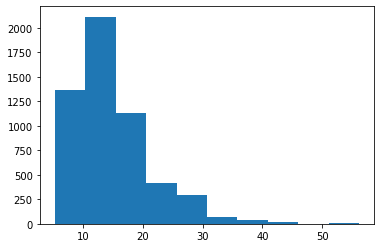

In [380]:
plt.hist(train_Y_age)

Create Transfomer Model and pre-train on swapped rois task

In [442]:
# Add classifcation token to beginning of input
# classifcation token is an array of 0's and will be the input to the downstream classification tasks
def add_cls_token(X, Y, swap=True, N=1):
  # cls_array = np.zeros((X.shape[0], N, N_rois))
  cls_array = np.ones((X.shape[0], N, N_rois))
  t_X = np.append(cls_array, X, 1)
  X = t_X
  if swap:
    zeros_ar = np.zeros((Y.shape[0],))[...,None] # None needed to keep shape
    t_Y = np.append(zeros_ar, Y, 1)
  else:
    t_Y = Y
  return t_X, t_Y

In [443]:
swap = False
N = 4 # Number of CLS tokens to add
train_X_t, train_Y_t = add_cls_token(train_X, train_Y, swap, N) 
val_X_t, val_Y_t = add_cls_token(val_X, val_Y, swap, N)
if(test_per > 0): 
  test_X_t, test_Y_t = add_cls_token(test_X, test_Y, swap, N) 

In [444]:
del train_X, train_Y, val_X, val_Y

In [445]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [446]:
class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.maxlen = maxlen
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=self.maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions

In [447]:
def precision(y_true, y_pred):
  '''
  tp/(tp + fp)
  '''
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  return true_positives / (predicted_positives + K.epsilon())

In [448]:
def recall(y_true, y_pred): 
  '''
  tp / (tp + fn)
  '''
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  return true_positives / (possible_positives + K.epsilon())

In [449]:
def specificity(y_pred, y_true):
    """
    tn / (tn + fp)
    """
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity

In [389]:
def f1_loss(y_true, y_pred):
  tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
  tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
  fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
  fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

  p = tp / (tp + fp + K.epsilon())
  r = tp / (tp + fn + K.epsilon())
  s = tn / (tn + fp + K.epsilon())

  f1 = 2*p*r / (p+r+K.epsilon())
  f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
  # return 1 - K.mean(f1)
  return 1 - p*p*r*r*s

In [390]:
def vec_dist_loss(y_true, y_pred):
  s = y_true - y_pred
  output = K.sum(s ** 2,axis=1,keepdims=True)
  y_true_val = K.sum(y_true **2, axis=1, keepdims=True)
  return output 

In [391]:
# returns lr for first ten epochs and exponentially decreases after
def lr_scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [392]:
class callback(keras.callbacks.Callback):
    def __init__(self, model, X_train):
        self.model = model
        self.x = X_train

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        # inp = self.model.input  # input placeholder
        inp = self.x
        outputs = self.model.layers[0].output  # get output of N's layer
        functors = K.function([inp, K.learning_phase()], [outputs])
        layer_outs = functors([self.x, 1.])
        print('\r OUTPUT TENSOR : %s' % layer_outs)

        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [459]:
embed_dim = N_rois  # Embedding size for each token
num_heads = 8  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
max_len = L + N
dropout_rate = .5

inputs = layers.Input(shape=(max_len, embed_dim))
pos_embedding_layer = PositionEmbedding(max_len, embed_dim)
x = pos_embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x1 = x[:, 0, :] # just use cls token
x2 = x[:, 1, :] # just use cls token
x3 = x[:, 2, :] # just use cls token
x4 = x[:, 3, :]

K.print_tensor(x1)

# Next activation prediction
x1 = layers.Dropout(dropout_rate )(x1)
x1 = layers.Dense(200, activation="relu")(x1)
# x1 = layers.Dropout(.1)(x1)
x1 = layers.Dense(200, activation="linear", name="next_pred")(x1)

# Gender Classification
x2 = layers.Dropout(dropout_rate)(x2)
x2 = layers.Dense(20, activation="relu")(x2)
x2 = layers.Dropout(dropout_rate)(x2)
x2 = layers.Dense(1, activation="sigmoid", name="gender")(x2)
# x2 = layers.Dense(1, activation="sigmoid")(x2)
# x = layers.Dropout(dropout_rate)(x)
# x = layers.Dense(20, activation="relu")(x)
# x = layers.Dropout(dropout_rate)(x)
# x = layers.Dense(1, activation="sigmoid", name="gender")(x)

# Age Prediction
x3 = layers.Dropout(dropout_rate )(x3)
x3 = layers.Dense(20, activation="relu")(x3)
x3 = layers.Dropout(dropout_rate)(x3)
x3 = layers.Dense(1, activation="linear", name="age")(x3)

# ASD Classification
x4 = layers.Dropout(dropout_rate)(x4)
x4 = layers.Dense(20, activation="relu")(x4)
x4 = layers.Dropout(dropout_rate)(x4)
x4 = layers.Dense(1, activation="sigmoid", name="asd")(x4)
# x2 = layers.Dense(1, activation="sigmoid")(x2)
# x = layers.Dropout(dropout_rate)(x)
# x = layers.Dense(20, activation="relu")(x)
# x = layers.Dropout(dropout_rate)(x)
# x = layers.Dense(1, activation="sigmoid", name="gender")(x)
outputs = [x1, x2, x3, x4]
# outputs = x1


model_embed = keras.Model(inputs=inputs, outputs=outputs)

# loss = custom_loss(recall_weight=0.9, spec_weight=0.1)
# metrics = [tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()]
# metrics = [recall, precision, specificity]
# metrics = ['mse', vec_dist_loss]

# opt = keras.optimizers.Adam(learning_rate=0.1)
loss_weights = [1e-2,0,1e-2, 1]
# loss_weights = [1,0,0]

model_embed.compile(loss=[vec_dist_loss, 'binary_crossentropy', 'mse', 'binary_crossentropy'], 
                    optimizer='adam', metrics={'gender': 'accuracy', 'asd': 'accuracy'}
                    , loss_weights=loss_weights)
# model_embed.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model_embed.compile(loss=vec_dist_loss, optimizer='adam', metrics=[vec_dist_loss])
model_embed.summary()

Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 94, 200)]    0                                            
__________________________________________________________________________________________________
position_embedding_33 (Position (None, 94, 200)      18800       input_35[0][0]                   
__________________________________________________________________________________________________
transformer_block_33 (Transform (None, 94, 200)      1298832     position_embedding_33[0][0]      
__________________________________________________________________________________________________
tf.__operators__.getitem_103 (S (None, 200)          0           transformer_block_33[0][0]       
___________________________________________________________________________________________

In [ ]:
batch_size = 64
epochs = 100
# es_callback = keras.callbacks.EarlyStopping(monitor='val_vec_dist_loss', patience=15)
es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=8)
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

history = model_embed.fit(train_X_t, [train_Y_pred_n, train_Y_gen, train_Y_age, train_Y_asd], batch_size=batch_size, epochs=epochs, validation_data=(val_X_t, [val_Y_pred_n, val_Y_gen, val_Y_age, val_Y_asd]), callbacks=[es_callback, lr_callback])
# history = model_embed.fit(train_X_t, train_Y_pred_n, batch_size=batch_size, epochs=epochs, validation_data=(val_X_t, val_Y_pred_n), callbacks=[es_callback, lr_callback])

Epoch 1/100
253/253 [==============================] - 13s 43ms/step - loss: 4.3625 - next_pred_loss: 240.8962 - gender_loss: 0.8435 - age_loss: 118.1251 - asd_loss: 0.7723 - gender_accuracy: 0.5958 - asd_accuracy: 0.5012 - val_loss: 2.8960 - val_next_pred_loss: 162.0823 - val_gender_loss: 0.6455 - val_age_loss: 58.2010 - val_asd_loss: 0.6932 - val_gender_accuracy: 0.8060 - val_asd_accuracy: 0.5029
Epoch 2/100
253/253 [==============================] - 10s 41ms/step - loss: 3.5872 - next_pred_loss: 218.0708 - gender_loss: 1.0747 - age_loss: 71.2725 - asd_loss: 0.6938 - gender_accuracy: 0.5160 - asd_accuracy: 0.5170 - val_loss: 3.0090 - val_next_pred_loss: 162.0907 - val_gender_loss: 0.4601 - val_age_loss: 69.4680 - val_asd_loss: 0.6934 - val_gender_accuracy: 0.8757 - val_asd_accuracy: 0.5029
Epoch 3/100
253/253 [==============================] - 11s 42ms/step - loss: 3.3748 - next_pred_loss: 205.3709 - gender_loss: 1.0886 - age_loss: 62.7367 - asd_loss: 0.6937 - gender_accuracy: 0.5181

In [395]:
del model_embed

In [ ]:
# evaluate the model
# _, train_mse, train_vec_dist = model_embed.evaluate(train_X_t, train_Y_t, verbose=0)
# _, test_mse, test_vec_dist = model_embed.evaluate(test_X_t, test_Y_t, verbose=0)
# print('Loss: Train: %.3f, Test: %.3f' % (train_vec_dist, test_vec_dist))
# print('MSE: Train: %.3f, Test: %.3f' % (train_mse, test_mse))
train_acc = model_embed.evaluate(train_X_t, [train_Y_pred_n, train_Y_gen, train_Y_age], verbose=0)
test_acc = model_embed.evaluate(test_X_t, [test_Y_pred_n, test_Y_gen, test_Y_age], verbose=0)
print('Train:')
print(train_acc)
print('Test:')
print(test_acc)

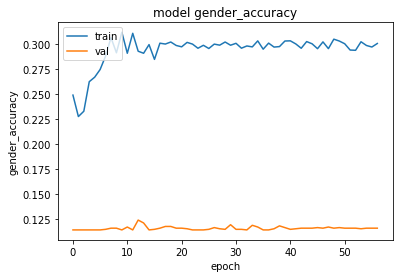

<Figure size 432x288 with 0 Axes>

In [458]:
def plt_training(var, skip=0, exp_name=None):
  plt.plot(history.history[var][skip:])
  plt.plot(history.history['val_' + var][skip:])
  plt.title('model ' + var)
  plt.ylabel(var)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  if exp_name is not None:
    plt.savefig(f'{exp_name}_{var}.png')

exp_name = 'L90_8_32_asd_nogen'
vars = ['loss', 'next_pred_loss', 'gender_loss', 'age_loss','asd_loss', 'gender_accuracy', 'asd_accuracy']
skip = 1
plt_training(vars[5], skip, exp_name)

In [ ]:
train_X_t.shape

(65160, 13, 200)

In [ ]:
x = train_X_t[10]
x = np.array([x])
pred_1 = model_embed.predict(x)
print(pred[0])

[[-5.80685353e-03  7.00870901e-03 -5.30468533e-03 -4.67797928e-03
  -8.40399228e-03 -2.01184792e-03  1.57812634e-03  5.49251586e-03
   3.36841517e-03 -4.92243189e-03  1.12116523e-02  7.91327562e-03
   1.58481445e-04  1.01462258e-02 -2.61165504e-03 -9.14084550e-04
   9.11390758e-04 -1.43703781e-02  1.08394306e-03  9.33996961e-03
  -1.86318671e-03 -7.21908547e-03  1.07470239e-02  1.47122890e-03
  -4.00586141e-04 -3.58088571e-03 -1.58564723e-03 -2.57585035e-03
   6.79692579e-03 -1.32695604e-02  4.04647598e-03  9.52751748e-03
  -7.86024961e-04 -4.39785683e-04 -9.74613335e-03  5.88800851e-03
  -3.40825506e-03  7.20302109e-03  9.68248211e-03  2.39070365e-03
  -3.72078526e-03  9.15440358e-03 -7.45086232e-04 -3.06080421e-03
  -5.42938011e-03  1.12202931e-02 -8.89557693e-03 -9.51128732e-03
   9.08031315e-03  2.76662200e-03 -2.32608698e-04 -7.91576691e-03
   1.62039883e-02  6.21570554e-03  1.74448406e-03  6.97453413e-03
   4.26503364e-03  7.52499327e-05  5.50327869e-03  5.34584187e-03
   5.86211

In [ ]:
sum(pred[0])

array([-5.80685353e-03,  7.00870901e-03, -5.30468533e-03, -4.67797928e-03,
       -8.40399228e-03, -2.01184792e-03,  1.57812634e-03,  5.49251586e-03,
        3.36841517e-03, -4.92243189e-03,  1.12116523e-02,  7.91327562e-03,
        1.58481445e-04,  1.01462258e-02, -2.61165504e-03, -9.14084550e-04,
        9.11390758e-04, -1.43703781e-02,  1.08394306e-03,  9.33996961e-03,
       -1.86318671e-03, -7.21908547e-03,  1.07470239e-02,  1.47122890e-03,
       -4.00586141e-04, -3.58088571e-03, -1.58564723e-03, -2.57585035e-03,
        6.79692579e-03, -1.32695604e-02,  4.04647598e-03,  9.52751748e-03,
       -7.86024961e-04, -4.39785683e-04, -9.74613335e-03,  5.88800851e-03,
       -3.40825506e-03,  7.20302109e-03,  9.68248211e-03,  2.39070365e-03,
       -3.72078526e-03,  9.15440358e-03, -7.45086232e-04, -3.06080421e-03,
       -5.42938011e-03,  1.12202931e-02, -8.89557693e-03, -9.51128732e-03,
        9.08031315e-03,  2.76662200e-03, -2.32608698e-04, -7.91576691e-03,
        1.62039883e-02,  

In [ ]:
train_Y_pred_n[0]

array([[-2.96294264e-01],
       [-1.90173461e+00],
       [-1.55800871e+00],
       [-6.77506864e-02],
       [-4.91607182e-01],
       [-6.11012321e-02],
       [-1.28264352e-01],
       [ 3.69203950e-01],
       [-7.05338678e-02],
       [ 1.70980964e-01],
       [-1.17186140e+00],
       [-6.65373203e-01],
       [ 2.56720584e-01],
       [-1.98820250e+00],
       [ 3.29306338e-01],
       [-2.02854950e-01],
       [-5.47978812e-01],
       [-4.88429757e-01],
       [-1.10110825e+00],
       [ 5.68499307e-01],
       [-2.64113917e-02],
       [-4.35135597e-01],
       [ 6.33459990e-01],
       [-4.17110836e-02],
       [ 2.87169149e-01],
       [ 7.63392462e-02],
       [ 1.21443515e-01],
       [ 8.32702380e-02],
       [-1.70849594e-01],
       [-2.16139362e-01],
       [ 4.01960511e-01],
       [-1.54628007e-01],
       [-9.73850244e-01],
       [ 3.58519707e-01],
       [-7.53234077e-02],
       [-2.56345016e-01],
       [-6.86558936e-01],
       [-6.55186576e-02],
       [ 9.6

In [ ]:
print(vec_dist_loss(pred[0], pred_1[0]))

tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


# Pretraining
num_heads = 8
ff_dim = 32
Train:
[0.14941030740737915, 0.9942409992218018, 2.342025254620239e-06, 0.0499839149415493, 0.9942409992218018, 1.0, 0.0499839149415493]
Test:
[8.86508560180664, 1.0045969486236572, 7.8084635734558105, 0.9561624526977539, 1.0045969486236572, 0.5303292870521545, 0.9561624526977539]

num_heads = 8
ff_dim = 32

num_heads = 8  
ff_dim = 32
# Gender acc:
* .25 drop: Train: 1.000, Test: 0.527
* .5 drop: Train: 0.999, Test: 0.520

# Age MSE:
* .25 drop: Train: 0.024, Test: 1.194
* .5 drop: Train: 0.103, Test: 1.277

# Next Pred:
* .25 drop: 
* .5 drop: Train: 0.994, Test: 1.000

num_heads = 4  
ff_dim = 32

# Age MSE:
* .5 drop: Train: 0.089, Test: 1.297

num_heads = 2  
ff_dim = 32

# Age MSE:
Train: 0.196, Test: 1.393

In [ ]:
x = np.array([train_X_t[15]])
a1 = model_embed.predict(x) 

In [ ]:
a2[0]

array([0.44724545], dtype=float32)

In [ ]:
a1[0]

array([0.44724545], dtype=float32)

In [ ]:
x = np.array([train_X_t[15]])
x2 = np.array([train_X_t[16]])

In [ ]:
x

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.00026516, -0.00479211, -0.01246446, ..., -0.00077214,
          0.00492293, -0.00260531],
        [-0.00364222, -0.00202805, -0.0139706 , ..., -0.00084743,
          0.0077697 , -0.00720413],
        ...,
        [-0.00709372,  0.01438538,  0.02005716, ...,  0.00049057,
          0.00275204,  0.00516073],
        [-0.00206024,  0.00569157,  0.0082498 , ...,  0.00015159,
         -0.00028173,  0.00468361],
        [ 0.00429784, -0.00625803, -0.01116405, ..., -0.00124895,
         -0.0043249 ,  0.0007013 ]]])

In [ ]:
x2

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-5.26466934e-05,  1.92892672e-03, -5.43647667e-03, ...,
         -1.12879740e-04, -3.44300153e-03,  5.06015294e-03],
        [-2.87038934e-03, -5.19179349e-03, -1.11219341e-02, ...,
          6.37216691e-05, -4.58006537e-03,  5.73129980e-03],
        ...,
        [ 7.04238153e-03, -3.24570940e-03, -2.58997803e-03, ...,
          1.62201403e-03, -3.48030905e-03,  7.16185485e-03],
        [-1.80642501e-03, -1.85231210e-03, -4.42355203e-03, ...,
          7.24248218e-04, -3.54382731e-03,  5.88919315e-03],
        [-1.15515802e-02,  7.53222816e-03, -3.46211729e-03, ...,
          1.64056075e-05, -2.54555417e-03,  5.88229557e-03]]])